### Predicting whether a particular move on Rotten Tomatoes is labeled as 'Rotten', 'Fresh', or 'Certified-Fresh'.

<a id=’Approach1’></a>
### Aproach 1: Predicting using Numerical and Categorical Features

In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.utils.class_weight import compute_class_weight
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_confusion_matrix, classification_report, confusion_matrix, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

In [4]:
df = pd.read_csv("rotten_tomatoes_movies.csv")
df.head()

,rotten_tomatoes_link,movie_title,movie_info,critics_consensus,content_rating,genres,directors,authors,actors,original_release_date,...,production_company,tomatometer_status,tomatometer_rating,tomatometer_count,audience_status,audience_rating,audience_count,tomatometer_top_critics_count,tomatometer_fresh_critics_count,tomatometer_rotten_critics_count
0,m/0814255,Percy Jackson & the Olympians: The Lightning T...,"Always trouble-prone, the life of teenager Per...",Though it may seem like just another Harry Pot...,PG,"Action & Adventure, Comedy, Drama, Science Fic...",Chris Columbus,"Craig Titley, Chris Columbus, Rick Riordan","Logan Lerman, Brandon T. Jackson, Alexandra Da...",2010-02-12,...,20th Century Fox,Rotten,49.0,149.0,Spilled,53.0,254421.0,43,73,76
1,m/0878835,Please Give,Kate (Catherine Keener) and her husband Alex (...,Nicole Holofcener's newest might seem slight i...,R,Comedy,Nicole Holofcener,Nicole Holofcener,"Catherine Keener, Amanda Peet, Oliver Platt, R...",2010-04-30,...,Sony Pictures Classics,Certified-Fresh,87.0,142.0,Upright,64.0,11574.0,44,123,19
2,m/10,10,"A successful, middle-aged Hollywood songwriter...",Blake Edwards' bawdy comedy may not score a pe...,R,"Comedy, Romance",Blake Edwards,Blake Edwards,"Dudley Moore, Bo Derek, Julie Andrews, Robert ...",1979-10-05,...,Waner Bros.,Fresh,67.0,24.0,Spilled,53.0,14684.0,2,16,8
3,m/1000013-12_angry_men,12 Angry Men (Twelve Angry Men),Following the closing arguments in a murder tr...,Sidney Lumet's feature debut is a superbly wri...,NR,"Classics, Drama",Sidney Lumet,Reginald Rose,"Martin Balsam, John Fiedler, Lee J. Cobb, E.G....",1957-04-13,...,Criterion Collection,Certified-Fresh,100.0,54.0,Upright,97.0,105386.0,6,54,0
4,m/1000079-20000_leagues_under_the_sea,"20,000 Leagues Under The Sea","In 1866, Professor Pierre M. Aronnax (Paul Luk...","One of Disney's finest live-action adventures,...",G,"Action & Adventure, Drama, Kids & Family",Richard Fleischer,Earl Felton,"James Mason, Kirk Douglas, Paul Lukas, Peter L...",1954-01-01,...,Disney,Fresh,89.0,27.0,Upright,74.0,68918.0,5,24,3


In [5]:
df.describe()

,runtime,tomatometer_rating,tomatometer_count,audience_rating,audience_count,tomatometer_top_critics_count,tomatometer_fresh_critics_count,tomatometer_rotten_critics_count
count,17398.000000,17668.000000,17668.000000,17416.000000,1.741500e+04,17712.000000,17712.000000,17712.000000
mean,102.214048,60.884763,57.139801,60.554260,1.439401e+05,14.586326,36.374831,20.703139
std,18.702511,28.443348,68.370047,20.543369,1.763577e+06,15.146349,52.601038,30.248435
min,5.000000,0.000000,5.000000,0.000000,5.000000e+00,0.000000,0.000000,0.000000
25%,90.000000,38.000000,12.000000,45.000000,7.075000e+02,3.000000,6.000000,3.000000
50%,99.000000,67.000000,28.000000,63.000000,4.277000e+03,8.000000,16.000000,8.000000
75%,111.000000,86.000000,75.000000,78.000000,2.498800e+04,23.000000,44.000000,24.000000
max,266.000000,100.000000,574.000000,100.000000,3.579764e+07,69.000000,497.000000,303.000000


<a id='preprocess'></a>
#### Data Preprocessing

In [11]:
numerical_feature = [feature for feature in df.columns if df[feature].dtypes != 'O']
discrete_feature=[feature for feature in numerical_feature if len(df[feature].unique())<25]
continuous_feature = [feature for feature in numerical_feature if feature not in discrete_feature]
categorical_feature = [feature for feature in df.columns if feature not in numerical_feature]
print("Numerical Features Count {}".format(len(numerical_feature)))
print("Discrete feature Count {}".format(len(discrete_feature)))
print("Continuous feature Count {}".format(len(continuous_feature)))
print("Categorical feature Count {}".format(len(categorical_feature)))

Numerical Features Count 8
Discrete feature Count 0
Continuous feature Count 8
Categorical feature Count 14


In [31]:
# For preprocessing we will have to encode the categorical columns since we are using sci-kit learn.
# But first, let us choose which features to include in the model.
categorical_feature

['rotten_tomatoes_link',
 'movie_title',
 'movie_info',
 'critics_consensus',
 'content_rating',
 'genres',
 'directors',
 'authors',
 'actors',
 'original_release_date',
 'streaming_release_date',
 'production_company',
 'tomatometer_status',
 'audience_status']

In [32]:
# From the categorical columns, we will use only "content_rating", and "audience_status". 
# "tomatometer_status" will be our target column.

In [18]:
def plot_feature(column, df):
    print(f"{column} categories: {df[column].unique()}")
    
    ax = df[column].value_counts().plot(kind='bar', figsize=(12,9))
    ax.bar_label(ax.containers[0])

content_rating categories: ['PG' 'R' 'NR' 'G' 'PG-13' 'NC17']


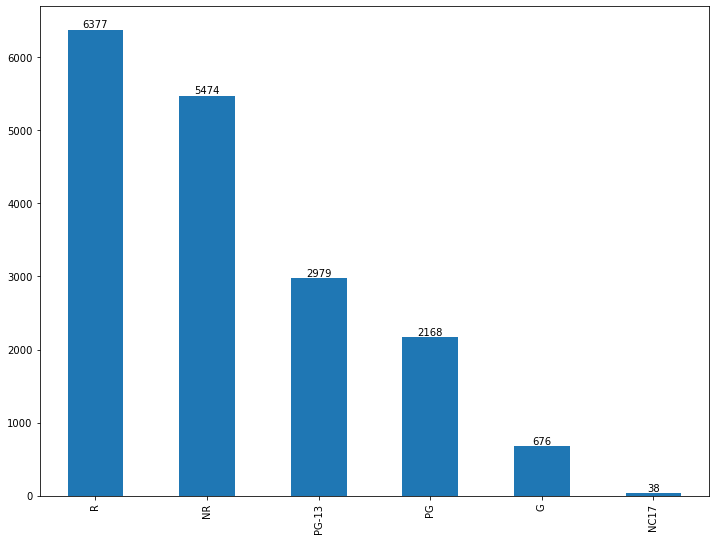

In [19]:
plot_feature('content_rating', df)

In [24]:
# One hot encoding
content_rating = pd.get_dummies(df.content_rating)
content_rating.head()

,G,NC17,NR,PG,PG-13,R
0,0,0,0,1,0,0
1,0,0,0,0,0,1
2,0,0,0,0,0,1
3,0,0,1,0,0,0
4,1,0,0,0,0,0


audience_status categories: ['Spilled' 'Upright' nan]


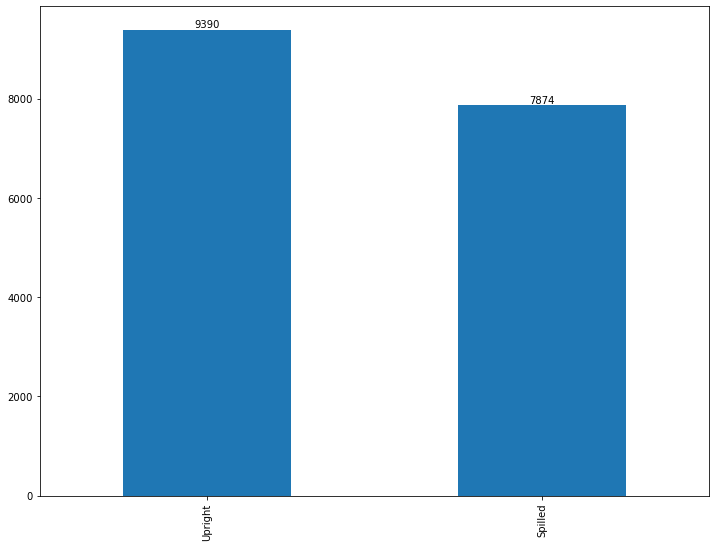

In [21]:
plot_feature('audience_status', df)

In [27]:
#Ordinal encoding for this column
audience_status = pd.DataFrame(df['audience_status'].replace(['Spilled', 'Upright'], [0,1]))
audience_status.head()

,audience_status
0,0.0
1,1.0
2,0.0
3,1.0
4,1.0


In [29]:
#Ordinal encoding for the target variable
tomatometer_status = pd.DataFrame(df['tomatometer_status'].replace(['Rotten','Fresh','Certified-Fresh'],[0,1,2]))
tomatometer_status

,tomatometer_status
0,0.0
1,2.0
2,1.0
3,2.0
4,1.0
...,...
17707,0.0
17708,2.0
17709,1.0
17710,1.0


In [34]:
# Combining all features in one dataframe
df_features = pd.concat([df[['runtime', 'tomatometer_rating', 'tomatometer_count', 'audience_rating', 'audience_count', 'tomatometer_top_critics_count', 'tomatometer_fresh_critics_count', 'tomatometer_rotten_critics_count']]
                         , content_rating, audience_status, tomatometer_status], axis=1).dropna()

In [35]:
df_features.head()

,runtime,tomatometer_rating,tomatometer_count,audience_rating,audience_count,tomatometer_top_critics_count,tomatometer_fresh_critics_count,tomatometer_rotten_critics_count,G,NC17,NR,PG,PG-13,R,audience_status,tomatometer_status
0,119.0,49.0,149.0,53.0,254421.0,43,73,76,0,0,0,1,0,0,0.0,0.0
1,90.0,87.0,142.0,64.0,11574.0,44,123,19,0,0,0,0,0,1,1.0,2.0
2,122.0,67.0,24.0,53.0,14684.0,2,16,8,0,0,0,0,0,1,0.0,1.0
3,95.0,100.0,54.0,97.0,105386.0,6,54,0,0,0,1,0,0,0,1.0,2.0
4,127.0,89.0,27.0,74.0,68918.0,5,24,3,1,0,0,0,0,0,1.0,1.0


In [36]:
# Checking the distribution of each feature
df_features.describe()

,runtime,tomatometer_rating,tomatometer_count,audience_rating,audience_count,tomatometer_top_critics_count,tomatometer_fresh_critics_count,tomatometer_rotten_critics_count,G,NC17,NR,PG,PG-13,R,audience_status,tomatometer_status
count,17017.000000,17017.000000,17017.000000,17017.000000,1.701700e+04,17017.000000,17017.000000,17017.000000,17017.000000,17017.000000,17017.000000,17017.000000,17017.000000,17017.000000,17017.000000,17017.000000
mean,102.296233,60.519539,57.097197,60.324499,1.471183e+05,14.765999,36.237292,20.871188,0.039314,0.002174,0.294940,0.124993,0.171593,0.366986,0.542928,0.752718
std,18.653649,28.436397,66.814580,20.480600,1.783955e+06,15.172256,51.362454,29.978900,0.194346,0.046580,0.456029,0.330720,0.377037,0.481997,0.498168,0.747250
min,5.000000,0.000000,5.000000,0.000000,5.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,90.000000,38.000000,12.000000,44.000000,7.410000e+02,3.000000,6.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,99.000000,66.000000,29.000000,62.000000,4.423000e+03,8.000000,17.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
75%,111.000000,86.000000,76.000000,77.000000,2.606700e+04,23.000000,44.000000,24.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000
max,266.000000,100.000000,535.000000,100.000000,3.579764e+07,69.000000,497.000000,303.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000


tomatometer_status categories: [0. 2. 1.]


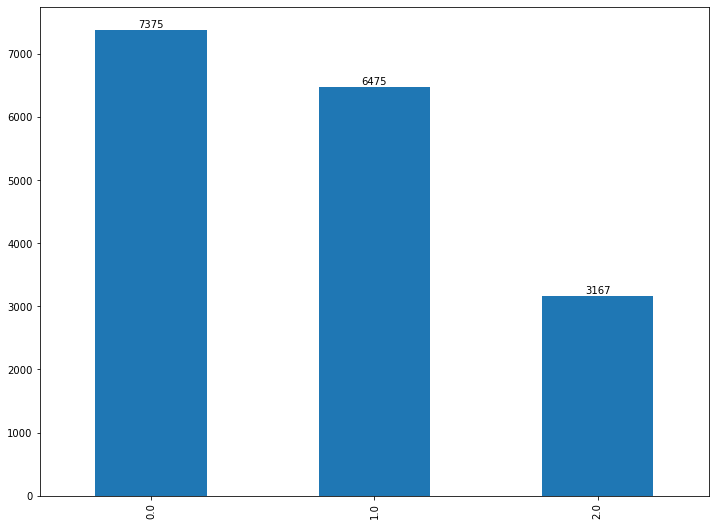

In [38]:
# Checking distribution of the target variable
plot_feature('tomatometer_status', df_features)

In [57]:
# Splitting dataset into training and testing datasets.
X_train, X_test, y_train, y_test = train_test_split(df_features.drop(['tomatometer_status'], axis=1), df_features.tomatometer_status, test_size= 0.2, random_state=42)
print(f"Training Dataset Size: {len(X_train)}\nTesting Dataset Size: {len(X_test)}")

Training Dataset Size: 13613
Testing Dataset Size: 3404


<a id='decision1'></a>
#### Decision Tree: Three Leaf Nodes

0.9462397179788484
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1488
         1.0       0.97      0.88      0.93      1286
         2.0       0.80      0.95      0.87       630

    accuracy                           0.95      3404
   macro avg       0.92      0.94      0.93      3404
weighted avg       0.95      0.95      0.95      3404



/Users/krishnatejbhat/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


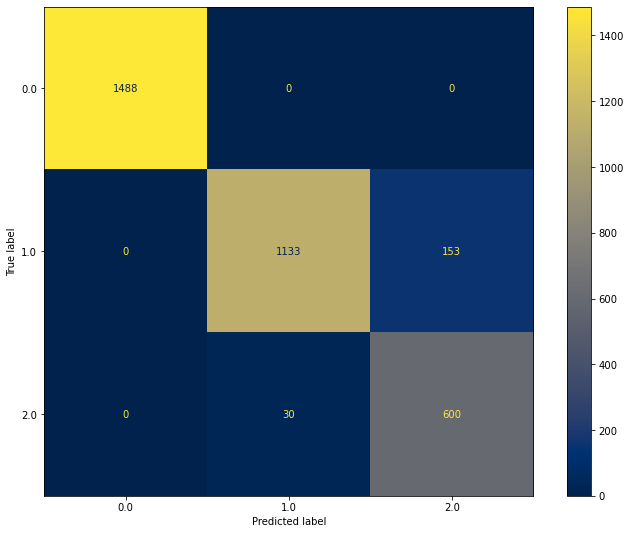

In [58]:
# Instantiating Decision Tree with maximum leaf node number = 3
tree_three = DecisionTreeClassifier(max_leaf_nodes=3, random_state=2)

tree_three.fit(X_train, y_train)

y_pred = tree_three.predict(X_test)

print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# plotting confusion matrix
fig, ax = plt.subplots(figsize=(12,9))
plot_confusion_matrix(tree_three, X_test, y_test, cmap='cividis', ax=ax)

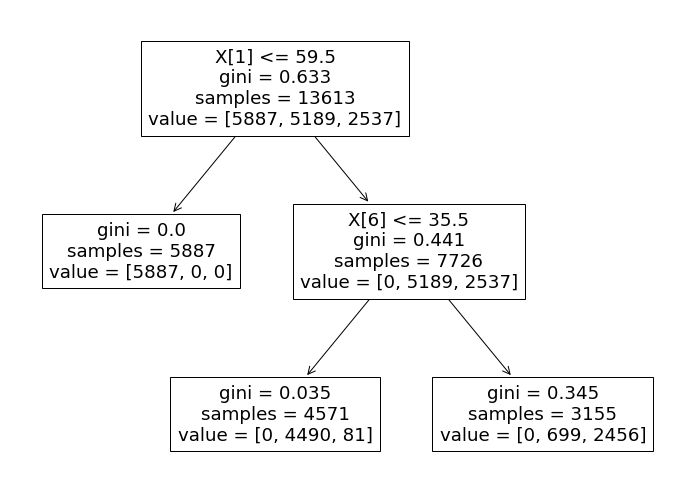

In [59]:
# Visualizing decision tree logic
fig, ax = plt.subplots(figsize=(12,9))
plot_tree(tree_three,ax=ax)
plt.show()

<a id='unconstrained'></a>
#### Decision Tree: Unconstrained

0.9903055229142186
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1488
         1.0       0.99      0.99      0.99      1286
         2.0       0.97      0.97      0.97       630

    accuracy                           0.99      3404
   macro avg       0.99      0.99      0.99      3404
weighted avg       0.99      0.99      0.99      3404



/Users/krishnatejbhat/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


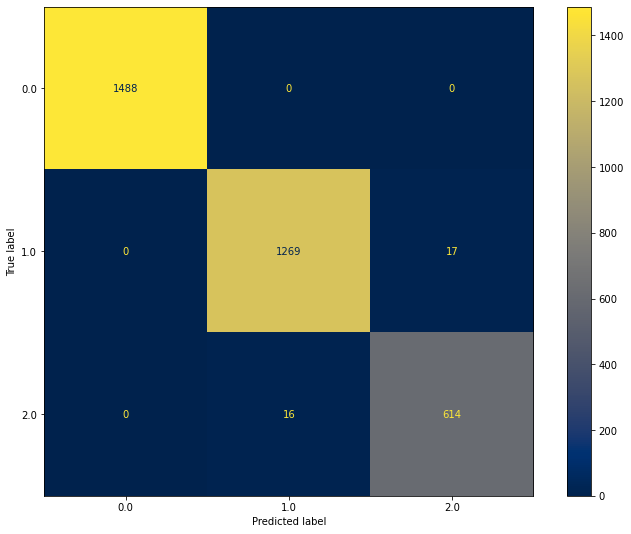

In [60]:
tree = DecisionTreeClassifier(random_state=3)

tree.fit(X_train, y_train)

y_pred = tree.predict(X_test)

print(accuracy_score(y_test, y_pred))
print(classification_report(y_test,y_pred))

# Plotting confusion matrix
fig, ax = plt.subplots(figsize=(12,9))
plot_confusion_matrix(tree, X_test, y_test, cmap='cividis', ax=ax)

<a id='RandomForest'></a>
#### Random Forest Classifier

0.9905992949471211
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1488
         1.0       0.99      0.99      0.99      1286
         2.0       0.98      0.97      0.97       630

    accuracy                           0.99      3404
   macro avg       0.99      0.99      0.99      3404
weighted avg       0.99      0.99      0.99      3404



/Users/krishnatejbhat/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


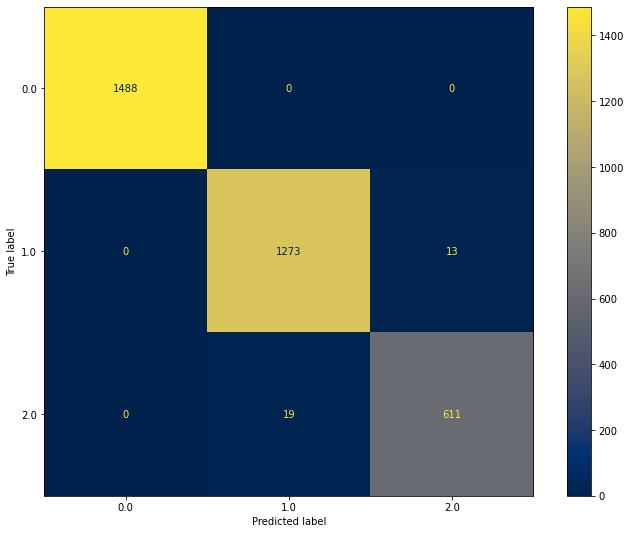

In [61]:
rf = RandomForestClassifier(random_state=1)

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

print(accuracy_score(y_test, y_pred))
print(classification_report(y_test,y_pred))

# Plotting confusion matrix
fig, ax = plt.subplots(figsize=(12,9))
plot_confusion_matrix(rf, X_test, y_test, cmap='cividis', ax=ax)

runtime = 0.005762604641945172
tomatometer_rating = 0.49399121081927844
tomatometer_count = 0.09190277703487777
audience_rating = 0.05744297531796365
audience_count = 0.015892479854644898
tomatometer_top_critics_count = 0.0379004124504513
tomatometer_fresh_critics_count = 0.14383622246853367
tomatometer_rotten_critics_count = 0.10832237490285046
G = 0.00043383034924117934
NC17 = 9.487661352547395e-06
NR = 0.007953136087221448
PG = 0.0004471096948162229
PG-13 = 0.001814486488944863
R = 0.001745527033620882
audience_status = 0.03254536519425747


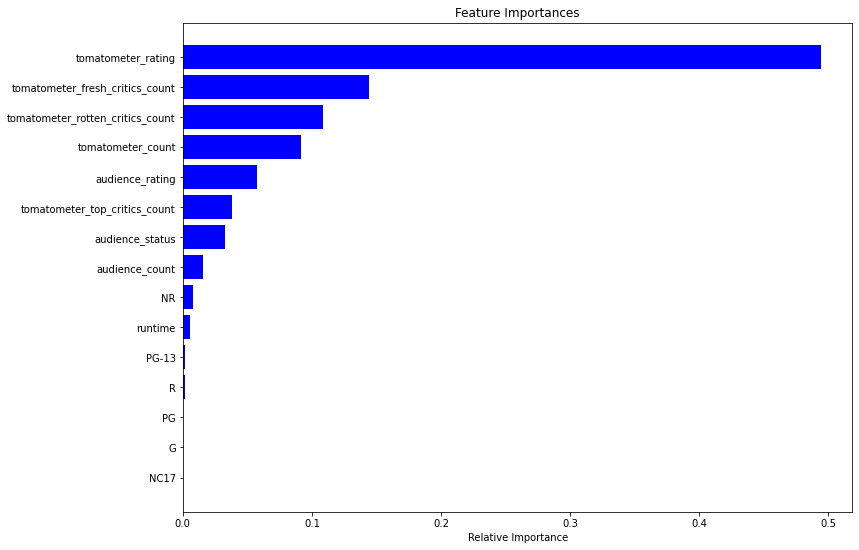

In [62]:
# Getting the feature importance
feature_imp = rf.feature_importances_

for i, feature in enumerate(X_train.columns):
    print(f"{feature} = {feature_imp[i]}")
    
impo = np.argsort(feature_imp)

plt.figure(figsize=(12,9))
plt.title('Feature Importances')
plt.barh(range(len(impo)), feature_imp[impo], color='b', align='center')
plt.yticks(range(len(impo)), [X_train.columns[i] for i in impo])
plt.xlabel('Relative Importance')
plt.show()

<a id='RandomForestFeature'></a>
#### Random Forest with Feature Selection

In [63]:
X_train, X_test, y_train, y_test = train_test_split(df_features.drop(columns=['tomatometer_status', 'NR', 'runtime', 'PG-13', 'R', 'PG','G', 'NC17'], axis=1), df_features['tomatometer_status'], test_size=0.2, random_state=41)
print(f"Training Dataset Size: {len(X_train)}\nTesting Dataset Size: {len(X_test)}")

Training Dataset Size: 13613
Testing Dataset Size: 3404


0.9926556991774383
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1449
         1.0       0.99      0.99      0.99      1302
         2.0       0.98      0.98      0.98       653

    accuracy                           0.99      3404
   macro avg       0.99      0.99      0.99      3404
weighted avg       0.99      0.99      0.99      3404



/Users/krishnatejbhat/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


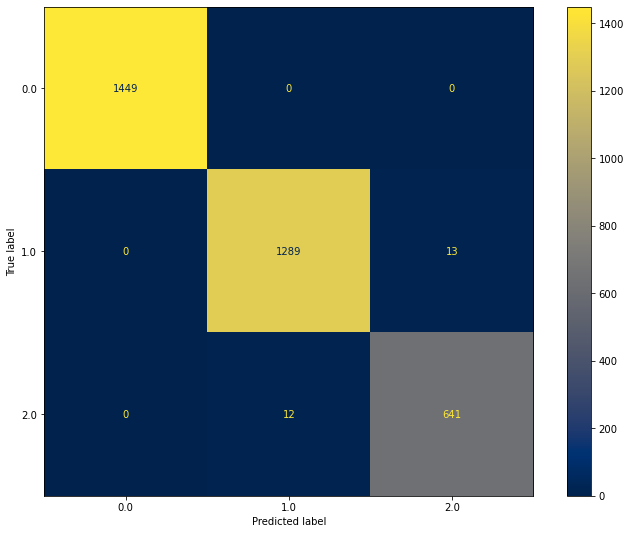

In [64]:
rf = RandomForestClassifier(random_state=1)

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

print(accuracy_score(y_test, y_pred))
print(classification_report(y_test,y_pred))

# Plotting confusion matrix
fig, ax = plt.subplots(figsize=(12,9))
plot_confusion_matrix(rf, X_test, y_test, cmap='cividis', ax=ax)

<a id='weighted'></a>
#### Weighted Random Forest with Feature Selection

[Text(0, 0, '7375'), Text(0, 0, '6475'), Text(0, 0, '3167')]

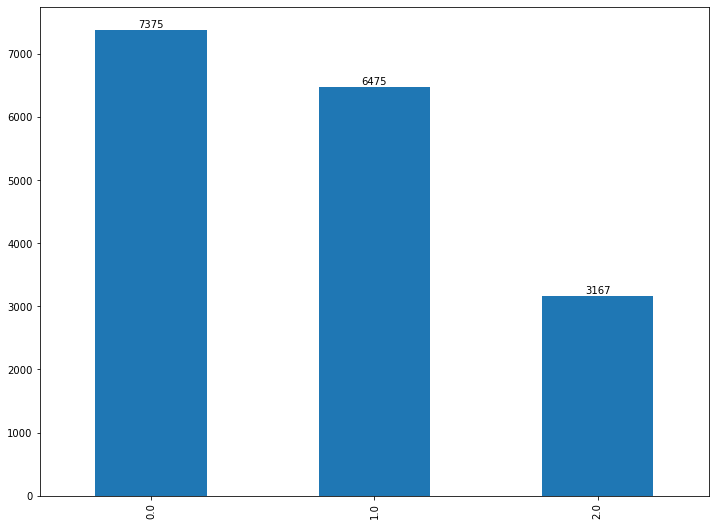

In [70]:
ax = df_features['tomatometer_status'].value_counts().plot(kind='bar', figsize=(12,9))
ax.bar_label(ax.containers[0])

In [72]:
classes = np.unique(df_features['tomatometer_status'])
y = df_features['tomatometer_status'].values

class_weight = compute_class_weight(class_weight='balanced', classes=classes, y=y)

weights_dict = dict(zip(range(len(list(class_weight))), list(class_weight)))
weights_dict

{0: 0.7691299435028248, 1: 0.8760360360360361, 2: 1.7910746237238186}

0.9932432432432432
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1449
         1.0       0.99      0.99      0.99      1302
         2.0       0.98      0.98      0.98       653

    accuracy                           0.99      3404
   macro avg       0.99      0.99      0.99      3404
weighted avg       0.99      0.99      0.99      3404



/Users/krishnatejbhat/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


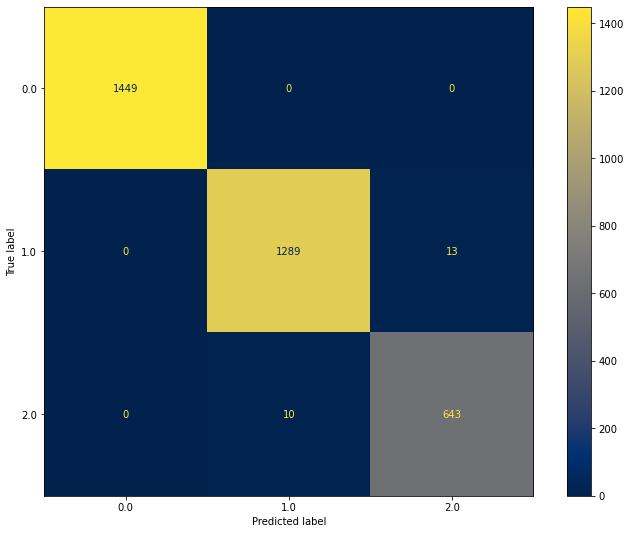

In [75]:
rf_weighted = RandomForestClassifier(random_state=5, class_weight=weights_dict)

rf_weighted.fit(X_train, y_train)

y_predict = rf_weighted.predict(X_test)

print(accuracy_score(y_test, y_predict))
print(classification_report(y_test, y_predict))

#Plotting the confusion matrix
fig, ax = plt.subplots(figsize=(12, 9))
plot_confusion_matrix(rf_weighted, X_test, y_test, cmap ='cividis', ax=ax)

<a id='Approach2'></a>
### Approach 2: Predicting Movie Status by Implementing Sentiment Analyses on Reviews

In [83]:
df_critics = pd.read_csv('rotten_tomatoes_critic_reviews_50k.csv')
df_critics.head()

,rotten_tomatoes_link,critic_name,top_critic,publisher_name,review_type,review_score,review_date,review_content
0,m/0814255,Andrew L. Urban,False,Urban Cinefile,Fresh,NaN,2010-02-06,A fantasy adventure that fuses Greek mythology...
1,m/0814255,Louise Keller,False,Urban Cinefile,Fresh,NaN,2010-02-06,"Uma Thurman as Medusa, the gorgon with a coiff..."
2,m/0814255,NaN,False,FILMINK (Australia),Fresh,NaN,2010-02-09,With a top-notch cast and dazzling special eff...
3,m/0814255,Ben McEachen,False,Sunday Mail (Australia),Fresh,3.5/5,2010-02-09,Whether audiences will get behind The Lightnin...
4,m/0814255,Ethan Alter,True,Hollywood Reporter,Rotten,NaN,2010-02-10,What's really lacking in The Lightning Thief i...


In [84]:
df_merged = df_critics.merge(df, how='inner', on='rotten_tomatoes_link')
df_merged = df_merged[['rotten_tomatoes_link', 'movie_title', 'review_content', 'review_type', 'tomatometer_status']]
df_merged.head()

,rotten_tomatoes_link,movie_title,review_content,review_type,tomatometer_status
0,m/0814255,Percy Jackson & the Olympians: The Lightning T...,A fantasy adventure that fuses Greek mythology...,Fresh,Rotten
1,m/0814255,Percy Jackson & the Olympians: The Lightning T...,"Uma Thurman as Medusa, the gorgon with a coiff...",Fresh,Rotten
2,m/0814255,Percy Jackson & the Olympians: The Lightning T...,With a top-notch cast and dazzling special eff...,Fresh,Rotten
3,m/0814255,Percy Jackson & the Olympians: The Lightning T...,Whether audiences will get behind The Lightnin...,Fresh,Rotten
4,m/0814255,Percy Jackson & the Olympians: The Lightning T...,What's really lacking in The Lightning Thief i...,Rotten,Rotten


In [85]:
df_merged = df_merged.dropna(subset=['review_content'])

[Text(0, 0, '25276'), Text(0, 0, '15919')]

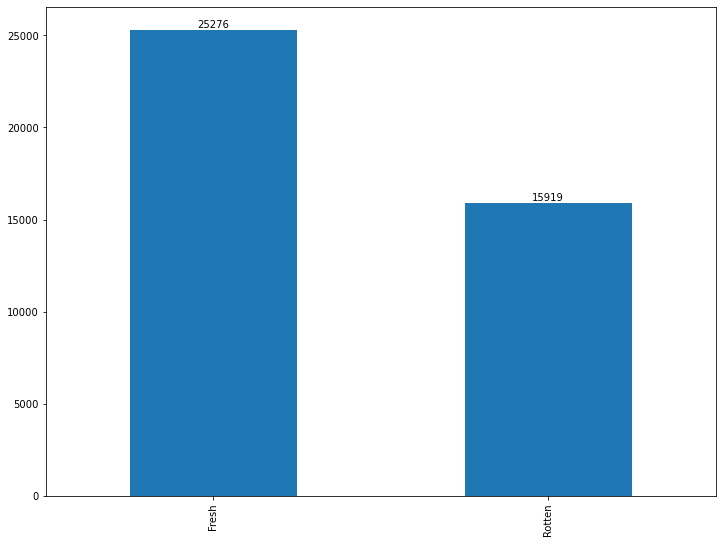

In [86]:
ax = df_merged.review_type.value_counts().plot(kind='bar', figsize=(12,9))
ax.bar_label(ax.containers[0])

In [87]:
# Picking only 5000 entried from the dataset
df_sub = df_merged[0:5000]

In [88]:
review_type = pd.DataFrame(df_sub.review_type.replace(['Rotten', 'Fresh'], [0,1]))

df_critics_features = pd.concat([df_sub['review_content'], review_type], axis=1).dropna()

In [89]:
df_critics_features.head(10)

,review_content,review_type
0,A fantasy adventure that fuses Greek mythology...,1
1,"Uma Thurman as Medusa, the gorgon with a coiff...",1
2,With a top-notch cast and dazzling special eff...,1
3,Whether audiences will get behind The Lightnin...,1
4,What's really lacking in The Lightning Thief i...,0
5,It's more a list of ingredients than a movie-m...,0
6,Harry Potter knockoffs don't come more transpa...,0
7,"Percy Jackson isn't a great movie, but it's a ...",1
8,"Fun, brisk and imaginative",1
9,"Crammed with dragons, set-destroying fights an...",1


In [91]:
X_train, X_test, y_train, y_test = train_test_split( df_critics_features['review_content'], df_critics_features['review_type'], test_size=0.2, random_state=42)

In [92]:
vectorizer = CountVectorizer(min_df=1)

X_train_vec = vectorizer.fit_transform(X_train).toarray()

              precision    recall  f1-score   support

           0       0.65      0.65      0.65       448
           1       0.72      0.72      0.72       552

    accuracy                           0.69      1000
   macro avg       0.68      0.68      0.68      1000
weighted avg       0.69      0.69      0.69      1000



/Users/krishnatejbhat/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


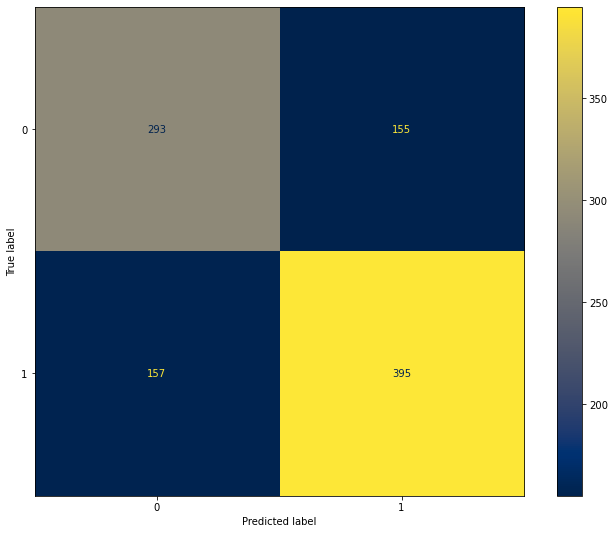

In [94]:
rf = RandomForestClassifier(random_state=2)
rf.fit(X_train_vec, y_train)

y_pred = rf.predict(vectorizer.transform(X_test).toarray())

print(classification_report(y_test, y_pred))

fig, ax = plt.subplots(figsize=(12,9))
plot_confusion_matrix(rf, vectorizer.transform(X_test).toarray(), y_test, cmap = 'cividis', ax=ax)

<a id='weightedRF'></a>
#### Weighted Random Forest

In [95]:
classes = np.unique(df_critics_features['review_type'])
y = df_critics_features['review_type'].values

class_weight = compute_class_weight(class_weight='balanced', classes=classes, y=y)

weights_dict = dict(zip(range(len(list(class_weight))), list(class_weight)))
weights_dict

{0: 1.058425063505504, 1: 0.9476876421531463}

              precision    recall  f1-score   support

           0       0.64      0.72      0.68       448
           1       0.74      0.67      0.70       552

    accuracy                           0.69      1000
   macro avg       0.69      0.69      0.69      1000
weighted avg       0.70      0.69      0.69      1000



/Users/krishnatejbhat/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


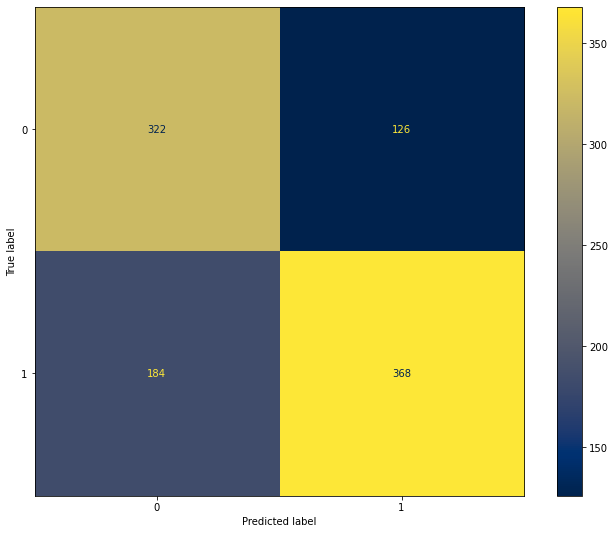

In [110]:
vectorizer = CountVectorizer(min_df=1)

X_train_vec = vectorizer.fit_transform(X_train).toarray()

rf_weighted = RandomForestClassifier(random_state=2, class_weight=weights_dict)
rf_weighted.fit(X_train_vec, y_train)

y_pred = rf.predict(vectorizer.transform(X_test).toarray())

print(classification_report(y_test, y_pred))

fig, ax = plt.subplots(figsize=(12,9))
plot_confusion_matrix(rf_weighted, vectorizer.transform(X_test).toarray(), y_test, cmap = 'cividis', ax=ax)

<a id='movie'></a>
#### Movie Status Prediction

In [112]:
def predict_status(prediction):
    """Assign label based on prediction"""
    positive_perc = (prediction == 1).sum()/len(prediction)*100
    
    prediction = 'Fresh' if positive_perc >= 60 else 'Rotten'
    
    print(f'Positive review:{positive_perc:.2f}%')
    print(f'Movie status: {prediction}')

<a id='Hamlet'></a>
#### Example Predictions

In [127]:
movies = ['Body of Lies', 'Angel Heart', 'The Duchess']

for movie in movies:
    print(movie)
    df_mov = df_merged[df_merged['movie_title'] == movie]
    y_pred_mov = rf_weighted.predict(vectorizer.transform(df_mov['review_content']).toarray())
    predict_status(y_pred_mov)
    print(df_merged[df_merged['movie_title'] == movie]['tomatometer_status'].unique())
    print("\n")

Body of Lies
Positive review:50.49%
Movie status: Rotten
['Rotten']


Angel Heart
Positive review:61.11%
Movie status: Fresh
['Fresh']


The Duchess
Positive review:60.12%
Movie status: Fresh
['Fresh']


